# Model Climate-Biosphere Interactions

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd
import os

### Constants and parameters

In [2]:
# Define the constants and parameters
# (a) Carbon cycle parameters 
ca0 = 589  # Pre-industrial atmospheric carbon stock (PgC)
ct0 = 1875  # Pre-industrial terrestrial carbon stock (PgC)
cm0 = 900  # Pre-industrial ocean mixed layer carbon stock (PgC)

lambda_climate = 1.8  # Transient climate sensitivity (K)
tau = 4  # Climate lag (years)

NPP0 = 55  # Pre-industrial net primary productivity (PgC/year)
w0 = 0.1  # Solubility pump rate (year^-1)
wT = 0.1  # Weakening of overturning circulation with climate change (1/K)
D = 1  # Atmosphere-ocean CO2 diffusion (year^-1)
r = 12.5  # Revelle factor (buffer factor)
DT = 0.0423  # Reduction of solubility with temperature (1/K)
B0 = 13 # Pre-industrial biological pump (PgC/year)
BT = 0.032 # Temperature dependence of biological pump (1/K)
QR = 1.72  # Temperature dependence of respiration
KC = 0.3  # CO2 fertilization effect

# (b) Parameters for biosphere-climate interactions
theta = 0.26  # Exponent in biodiversity–function relationship
ICC = 0.05  # (0-0.1) Effect of climate change on biodiversity (1/K)
rg = 0.025  # (0.0125-0.0500) Response relaxation rate (1/year)
vmax = 0.02  # (0.01-0.04) Maximum response rate (K/year)
KA = 55  # (25-95) Terrestrial carbon storage loss due to response lag (PgC/K)
pT = 22.5  # (10-40) Permafrost thaw temperature response (PgC/K)
BA = 0.00019  # (0-0.00038) Acidification effect on marine biological pump (1/μatm)
BTB = 0.007  # (0-0.014) Temperature effect on marine biological pump (1/K)

### Time and RCP scenario dependent parameters

In [62]:
# Time and RCP scenario dependent parameters
# Define the RCP scenarios
scenarios = [2.6, 4.5, 6.0, 8.5]

# Emissions and LUC
emissions = {}   # Fossil fuel emissions (PgC/year) depending on RCP scenarios
LUC = {}  # Land-use emissions (PgC/year) depending on RCP scenarios

## Load emissions and LUC for RCP scenarios
current_dir = os.path.dirname(os.path.abspath('pycopancore_bbc')) # Get the current script directory
for scenario in scenarios: 
    # Loop through the scenarios and load the corresponding CSV files
    file_path_emissions = os.path.join(current_dir, 'input', f'Emissions{scenario}.csv')
    emissions[f'RCP{scenario}'] = pd.read_csv(file_path_emissions, header=None)
    emissions[f'RCP{scenario}'].columns = ['year', 'emissions']

    file_path_LUC = os.path.join(current_dir, 'input', f'LUC{scenario}.csv')
    LUC[f'RCP{scenario}'] = pd.read_csv(file_path_LUC, header=None)
    LUC[f'RCP{scenario}'].columns = ['year', 'LUC']
   

## Get emissions for certain time and RCP scenario
def emissions_RCP(t, scenario=8.5):
    year = np.floor(t)
    if f'RCP{scenario}' in emissions:
        if year in emissions[f'RCP{scenario}']['year'].values:
            return emissions[f'RCP{scenario}'].loc[emissions[f'RCP{scenario}']['year'] == year, 'emissions'].values[0]
        else:
            # Interpolation if year is not found
            return np.interp(year, emissions[f'RCP{scenario}']['year'], emissions[f'RCP{scenario}']['emissions'])
    else:
        raise ValueError(f"Invalid scenario, possible RCP scenarios are: {list(emissions.keys())}")

## Get LUC for certain time and RCP scenario
def LUC_RCP(t, scenario=8.5):
    year = np.floor(t)
    if f'RCP{scenario}' in LUC:
        if year in LUC[f'RCP{scenario}']['year'].values:
            return LUC[f'RCP{scenario}'].loc[LUC[f'RCP{scenario}']['year'] == year, 'LUC'].values[0]
        else:
            # Interpolation if year is not found
            return np.interp(year, LUC[f'RCP{scenario}']['year'], LUC[f'RCP{scenario}']['LUC'])
    else:
        raise ValueError(f"Invalid scenario, possible RCP scenarios are: {list(LUC.keys())}")

# Impact on BD
# Id   # Direct human impacts on biodiversity

## Get Id for certain time and RCP scenario
## Formular from Hannahs code (\pycopancore-BBC-model\pycopancore\model_components\BBC\implementation\world.py)
def Id_RCP(t, scenario=8.5):
    if scenario in scenarios:
        additional_impact = [0.1, 0.12, 0.14, 0.18] # for each scenario
        return 0.1 * min(t - 1765 / (2000 - 1765), 1) + additional_impact[scenarios.index(scenario)] * max(0, (t - 2000) / (2100 - 2000))
    else:
        raise ValueError(f"Invalid scenario, possible RCP scenarios are: {scenarios}")

### Variables
Just to get the overview

In [48]:
# Variables
# t   # Time since 1765

# T   # Current GMST (K)
# Delta_T   # Change in GMST from pre-industrial to current (K) 
# z   # GMST to which species are currently best adapted (K)
# Delta_z   # Change in best adapted GMST from pre-industrial to current (?) (K) 

# ca   # Atmospheric carbon
# ct   # Terrestrial carbon
# cm   # Ocean mixed layer carbon
# cp   # Carbon from permafrost thaw
# cs   # System carbon (contributed by fossil fuel emissions and biological pump)

### Initial conditions

In [49]:
# Initial conditions
Delta_T0 = 0  # Initial temperature anomaly (°C)
Delta_z0 = 0  # Initial response lag (°C)

ca_init = ca0  # Initial atmospheric carbon stock (PgC)
ct_init = ct0  # Initial terrestrial carbon stock (PgC)
cm_init = cm0  # Initial ocean mixed layer carbon stock (PgC)
cp_init = 0  # Initial carbon stock from permafrost thaw (PgC), set to zero as per the paper
cs_init = 0  # Initial change in 'system carbon' (PgC), set to zero as per the paper

### Model

In [63]:
# Define the model
def model(t, y, params, scenario):
    Delta_T, Delta_z, ca, ct, cm, cp, cs = y 
    ca0, ct0, cm0, lambda_climate, tau, NPP0, w0, wT, D, r, DT, B0, BT, QR, KC, theta, ICC, rg, vmax, KA, pT, BA, BTB = params
    scenario = scenario

    # 2.1. Land
    # 2.1.1. Response lag & 2.1.2. Biodiversity loss
    response_lag = np.abs(Delta_T - Delta_z)

    ## Globally aggregated measure of biodiversity
    Id_t = Id_RCP(t, scenario)
    I = np.maximum(0, 1 - ICC * response_lag - Id_t)
            
    ## Biodiversity-dependent further slowing of species responses
    H = I ** theta 

    ## Terrestrial carbon carrying capacity
    if ca <= 0:
        ca = 1e-6  # Avoid log(0) which is undefined
    K = H * ((1 + KC * np.log(ca / ca0)) * ct0 * QR ** (-Delta_T / 10)) - KA * response_lag

    ## Terrestrial carbon equation
    LUC_t = LUC_RCP(t, scenario)
    dctdt = (NPP0 / ct0) * (QR ** (Delta_T / 10)) * (K - ct) - LUC_t

    ## Best-adapted GMST equation
    dDelta_zdt = vmax * H * np.tanh(rg * (Delta_T - Delta_z) / vmax) 

    # Temperature anomaly equation
    dDelta_Tdt = (lambda_climate / np.log(2) * np.log(ca / ca0) - Delta_T) / tau

    # 2.1.3. Permafrost thaw
    ## Permafrost carbon equation
    dcpdt = pT * max(dDelta_Tdt, 0)

    # 2.2. Ocean    
    ## Marine biological pump partial pressure
    cm = np.maximum(1e-6, cm)
    denominator = np.maximum(1e-6, 1 - DT * Delta_T)
    p = ca0 * ((cm / cm0) ** r) / denominator
    
    ## Marine biological pump efficiency
    B = B0 * (1 - BT * Delta_T - BTB * Delta_T) * (1 - BA * (p - ca0))
    
    ## Ocean mixed layer carbon equation
    dcmdt = (D * cm0 / (r * ca0)) * (ca - p) + B0 - B - w0 * (1 - wT * Delta_T) * (cm - cm0)

    # 2.3. Atmosphere
    ## System carbon equation
    e_t = emissions_RCP(t, scenario)
    dcsdt = e_t - w0 * (1 - wT * Delta_T) * (cm - cm0) - (B - B0)
    
    ## Atmospheric carbon equation based on conservation
    ca_conservation = ca0 + ct0 + cm0 + cs + cp - ct - cm
    dcadt = dcsdt + dcpdt - dctdt - dcmdt
    
    return [dDelta_Tdt, dDelta_zdt, dcadt, dctdt, dcmdt, dcpdt, dcsdt]

### Run Model

In [64]:
# Define initial conditions and parameters
y0 = [Delta_T0, Delta_z0, ca_init, ct_init, cm_init, cp_init, cs_init]
params = [ca0, ct0, cm0, lambda_climate, tau, NPP0, w0, wT, D, r, DT, B0, BT, QR, KC, theta, ICC, rg, vmax, KA, pT, BA, BTB]

# Define time span for the solution
t_span = (1765, 2100) 
t = np.linspace(t_span[0], t_span[1], t_span[1])

#### Carbon stocks for different scenarios

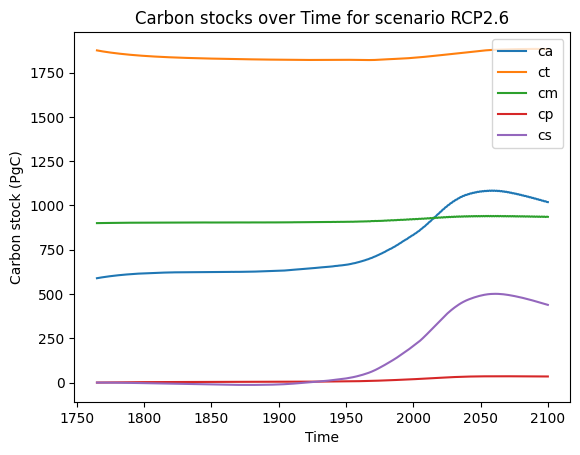

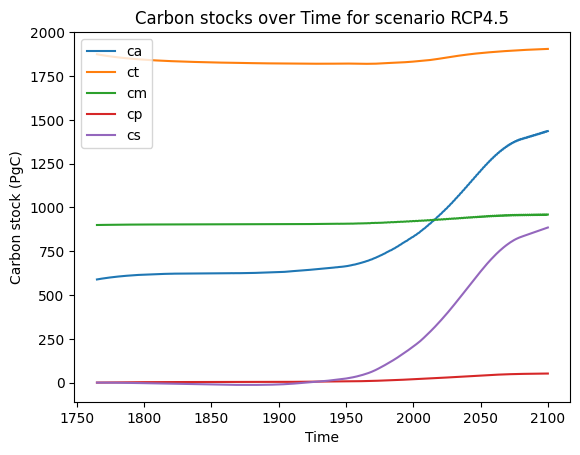

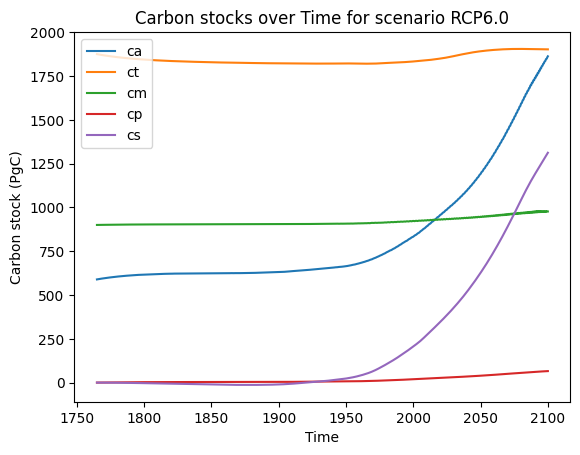

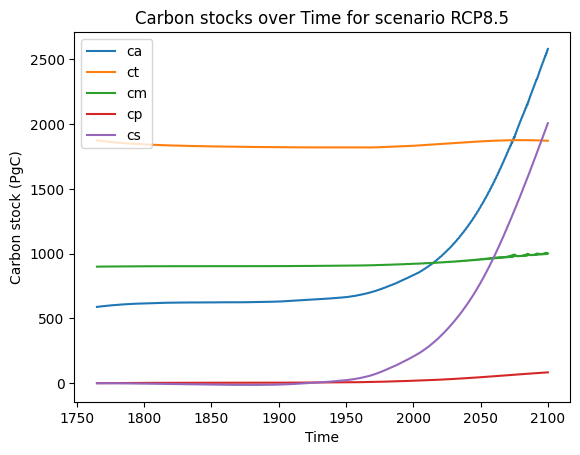

In [65]:
# Define output directory
output_dir = 'output_plots'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Plot the carbon stocks for different scenarios
for scenario in scenarios:
    solution = solve_ivp(model, t_span, y0, args=(params, scenario), dense_output=True)
    plt.plot(t, solution.sol(t)[2:].T)
    plt.xlabel('Time')
    plt.ylabel('Carbon stock (PgC)')
    plt.legend(['ca', 'ct', 'cm', 'cp', 'cs'])
    plt.title(f'Carbon stocks over Time for scenario RCP{scenario}')
    plt.savefig(os.path.join(output_dir, f'plot_scenario_{scenario}.png'))
    plt.show()

#### Temperature
Just for sanity check

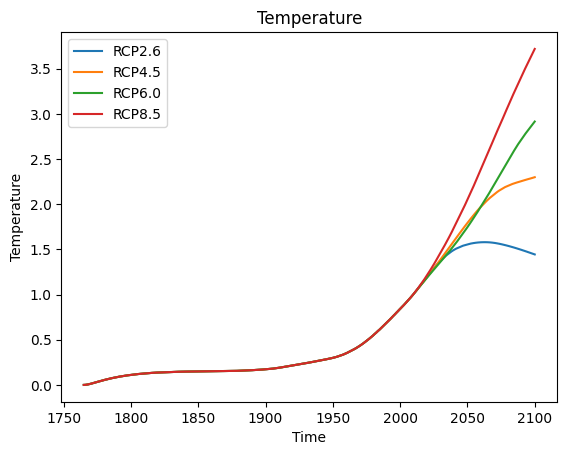

In [66]:
# Plot the carbon stocks for different scenarios
for scenario in scenarios:
    solution = solve_ivp(model, t_span, y0, args=(params, scenario), dense_output=True)
    plt.plot(t, solution.sol(t)[0].T)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5'])
plt.title(f'Temperature')
plt.savefig(os.path.join(output_dir, f'plot_temperature.png'))
plt.show()

#### Find steady states

In [67]:
from scipy.optimize import fsolve

# Define the function for root finding (steady-state conditions)
def steady_state(y, params, scenario):
    return model(0, y, params, scenario)

# Initial guess for the solver (same as initial conditions)
y_guess = y0

# Solve for the steady-state values
steady_state_sol = fsolve(steady_state, y_guess, args=(params, scenario))

# Extract the steady-state values
Delta_T_ss, Delta_z_ss, ca_ss, ct_ss, cm_ss, cp_ss, cs_ss = steady_state_sol

print(f'Steady-state values:\nTemperature Anomaly: {Delta_T_ss} °C\nResponse Lag: {Delta_z_ss} °C\n'
      f'Atmospheric Carbon: {ca_ss} PgC\nTerrestrial Carbon: {ct_ss} PgC\n'
      f'Ocean Mixed Layer Carbon: {cm_ss} PgC\nPermafrost Carbon: {cp_ss} PgC\nSystem Carbon: {cs_ss} PgC')


Steady-state values:
Temperature Anomaly: 0.0023134709734591724 °C
Response Lag: 0.0023134709767052767 °C
Atmospheric Carbon: 589.5249594658364 PgC
Terrestrial Carbon: 2169.3086726625315 PgC
Ocean Mixed Layer Carbon: 900.0541010183747 PgC
Permafrost Carbon: 366706.11585332174 PgC
System Carbon: 452119.09504918504 PgC
